# Downloading the dataset

In [ ]:
!pip install torch
!pip install torchvision

In [ ]:
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
!tar -xf wiki_crop.tar

--2025-01-07 17:38:01--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar.1’

wiki_crop.tar.1     100%[===================>] 773.73M  19.4MB/s    in 42s     

2025-01-07 17:38:44 (18.6 MB/s) - ‘wiki_crop.tar.1’ saved [811315200/811315200]



In [ ]:
import math
import os
import time
from datetime import datetime
from pathlib import Path
from glob import glob

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
from PIL import Image
import numpy as np

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Prepare Data

In [ ]:
def load_data(dataset='wiki', data_dir='./wiki_crop'):

    meta_path = Path(data_dir) / f'{dataset}.mat'
    meta = loadmat(meta_path)
    meta_data = meta[dataset][0, 0]

    full_path = meta_data['full_path'][0]
    full_path = [y for x in full_path for y in x]

    dob = meta_data['dob'][0]

    photo_taken = meta_data['photo_taken'][0]
    print(photo_taken)

    age = [calc_age(photo_taken[i], dob[i]) for i in range(len(dob))]

    clean_mapping = {pth:age for (pth, age) in zip(full_path, age) if age > 0}

    full_path = list(clean_mapping.keys())
    age = list(clean_mapping.values())

    return full_path, age

In [ ]:
def calc_age(taken, dob):

    birth = datetime.fromordinal(max(int(dob) - 366, 1))

    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

In [ ]:
def scale(x, feature_range=(-1, 1)):

    min, max = feature_range
    x = x * (max - min) + min
    return x

In [ ]:
bins = [18, 29, 39, 49, 59]
def one_hot(x, bins):

    x = x.numpy()
    idxs = np.digitize(x, bins, right=True)
    idxs = idxs.reshape(-1,1)
    z = torch.zeros(len(x), len(bins)+1).scatter_(1, torch.tensor(idxs), 1)
    return z

# Data Loader

In [ ]:
class ImageAgeDataset(Dataset):

    def __init__(self, dataset, data_dir, transform=None):

        self.data_dir = data_dir
        self.full_path, self.age = load_data(dataset, data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.age)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.data_dir, self.full_path[idx]))
        age = self.age[idx]
        sample = {'image': image, 'age': age}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:
class Resize(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.Resize(self.output_size)(image)
        return {'image': image, 'age': age}

class ToTensor(object):

    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.ToTensor()(image)
        if image.size()[0] == 1:
            image = image.expand(3,-1,-1)
        return {'image': image, 'age': age}

In [ ]:
dataset='wiki'
data_dir='./wiki_crop'
bins = [18, 29, 39, 49, 59]
img_size = 64
batch_size = 128

tfms = transforms.Compose([Resize((img_size, img_size)),
                           ToTensor()])

train_dataset = ImageAgeDataset(dataset, data_dir, transform=tfms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

In [ ]:
trainiter = iter(train_loader)
train = next(trainiter)

In [ ]:
# Get the image from the dataset
image1 = train_dataset[0]['image'].numpy()

# Convert the numpy array to PIL image
image_pil = Image.fromarray(np.uint8(image1.transpose((1, 2, 0)) * 255))

# Display the image
image_pil.show()

In [ ]:
# Get the image from the dataset
image2 = train_dataset[60941]['image'].numpy()

# Convert the numpy array to PIL image
image_pil = Image.fromarray(np.uint8(image2.transpose((1, 2, 0)) * 255))

# Display the image
image_pil.show()

In [ ]:
#plt.imshow(train_dataset[0]['image'].numpy().transpose(1,2,0))

In [ ]:
#plt.imshow(train_dataset[60941]['image'].numpy().transpose(1,2,0))

In [ ]:
from PIL import Image , ImageDraw

dataiter = iter(train_loader)
data = next(dataiter)
images, labels = data['image'], data['age']

fig = Image.new('RGB', (2500, 400))

plot_size=20
width = 125
height = 200

for idx in np.arange(plot_size):
    img = np.transpose(images[idx], (1, 2, 0))
    pil_img = Image.fromarray(np.uint8(img*255))
    pil_img = pil_img.resize((width, height), Image.Resampling.LANCZOS)
    fig.paste(pil_img, (idx*width, 0))
    draw = ImageDraw.Draw(fig)
    draw.text((idx*width+10, height+10), str(labels[idx].item()), fill='black')

fig.show()


In [ ]:
# dataiter = iter(train_loader)
# data = next(dataiter)
# images, labels = data['image'], data['age']

# fig = plt.figure(figsize=(25, 4))
# plot_size=20
# for idx in np.arange(plot_size):
#     ax = fig.add_subplot(2, plot_size//2, idx+1, xticks=[], yticks=[])
#     ax.imshow(np.transpose(images[idx], (1, 2, 0)))
#     ax.set_title(str(labels[idx].item()))

# Define Models

## Discriminator

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)

    if batch_norm:
        bn = nn.BatchNorm2d(out_channels)
        layers.append(bn)

    return nn.Sequential(*layers)

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, y_size, conv_dim=64):

        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.y_size = y_size
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim+y_size, conv_dim * 2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.conv5 = conv(conv_dim*8, 1, 4, 1, 0, batch_norm=False)

    def forward(self, x, y):

        x = F.relu(self.conv1(x))
        y = y.view(-1,y.size()[-1],1,1)
        y = y.expand(-1,-1,x.size()[-2], x.size()[-1])
        x = torch.cat([x, y], 1)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)

        return x

## Generator

In [ ]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):

    layers = []
    t_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(t_conv)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [ ]:
class Generator(nn.Module):

    def __init__(self, z_size, y_size, conv_dim=64):

        super(Generator, self).__init__()

        self.conv_dim = conv_dim

        self.t_conv1 = deconv(z_size+y_size, conv_dim*8, 4, 1, 0)
        self.t_conv2 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv3 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv4 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv5 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, z, y):

        x = torch.cat([z, y], dim=1)
        x = x.view(-1, x.size()[-1], 1, 1)
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        x = self.t_conv5(x)
        x = torch.tanh(x)

        return x

## Build complete network

In [ ]:
conv_dim = 64
z_size = 100
y_size = 6

D = Discriminator(y_size, conv_dim)
G = Generator(z_size, y_size, conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(70, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

Generator(
  (t_conv1): Sequential(
    (0): ConvTranspose2d(106, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05,

## Discriminator and Generator Losses

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [ ]:
import torch.optim as optim

lr = 0.0002
beta1=0.5
beta2=0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Training

In [ ]:
def checkpoint(G, D, epoch, model, root_dir):
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    G_path = os.path.join(target_dir, f'G_{epoch}.pkl')
    D_path = os.path.join(target_dir, f'D_{epoch}.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

def oh_to_class(fixed_y):
    age_map = {0:'0-18',1:'19-29',2:'30-39',3:'40-49',4:'50-59',5:'60+'}
    if torch.cuda.is_available():
        fixed_y = fixed_y.cpu()
    fixed_y_idxs = fixed_y.numpy().nonzero()[1]
    fixed_y_ages = [age_map[idx] for idx in fixed_y_idxs]

    return fixed_y_ages

def save_samples_ages(samples, fixed_y, model, root_dir):
    fixed_y_ages = oh_to_class(fixed_y)
    samples_ages = {'samples': samples, 'ages': fixed_y_ages}
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    with open(f'{target_dir}/train_samples_ages.pkl', 'wb') as f:
        pkl.dump(samples_ages, f)

In [ ]:
import os
import numpy as np
import torch
import pickle as pkl

root_dir = '/content/Age-cGAN'
model = 'GAN_1'
os.makedirs(root_dir, exist_ok=True)

G.to(device)
D.to(device)

num_epochs = 7

samples = []
losses = []

print_every = 300

sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_y = np.random.randint(len(bins), size=sample_size)
fixed_y = fixed_y.reshape(-1,1)
fixed_y = torch.zeros(sample_size, len(bins)+1).scatter_(1, torch.tensor(fixed_y, dtype=torch.long), 1)

for epoch in range(num_epochs):

    for batch_i, batch in enumerate(train_loader):
        batch_size = batch['image'].size(0)
        real_images = scale(batch['image'])
        ages = one_hot(batch['age'], bins)

        d_optimizer.zero_grad()

        real_images = real_images.to(device)
        ages = ages.to(device)

        D_real = D(real_images, ages)
        d_real_loss = real_loss(D_real)

        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        fake_images = G(z, ages)

        D_fake = D(fake_images, ages)
        d_fake_loss = fake_loss(D_fake)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        g_optimizer.zero_grad()

        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        fake_images = G(z, ages)

        D_fake = D(fake_images, ages)
        g_loss = real_loss(D_fake)

        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            losses.append((d_loss.item(), g_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    G.eval()
    fixed_z = fixed_z.to(device)
    fixed_y = fixed_y.to(device)
    samples_z = G(fixed_z, fixed_y)
    samples.append(samples_z.detach().cpu().numpy())
    G.train()

    # Save the model and optimizer state dicts
    checkpoint(G, D, epoch, model, root_dir)

# Save the samples and losses arrays
samples_file = os.path.join(root_dir, f'{model}_samples.pkl')
losses_file = os.path.join(root_dir, f'{model}_losses.pkl')
with open(samples_file, 'wb') as f:
    pkl.dump(samples, f)
with open(losses_file, 'wb') as f:
    pkl.dump(losses, f)

# Save the final model and optimizer state dicts
checkpoint(G, D, num_epochs, model, root_dir)

# Save the final samples array
save_samples_ages(samples, fixed_y, model, root_dir)


Epoch [    1/    5] | d_loss: 0.4110 | g_loss: 2.6976
Epoch [    1/    5] | d_loss: 0.2631 | g_loss: 3.2329
Epoch [    2/    5] | d_loss: 0.6027 | g_loss: 1.2894
Epoch [    2/    5] | d_loss: 0.3129 | g_loss: 3.9409
Epoch [    3/    5] | d_loss: 0.4896 | g_loss: 3.9765
Epoch [    3/    5] | d_loss: 0.1558 | g_loss: 3.1901
Epoch [    4/    5] | d_loss: 0.2465 | g_loss: 3.4188
Epoch [    4/    5] | d_loss: 0.0729 | g_loss: 3.7280
Epoch [    5/    5] | d_loss: 0.9264 | g_loss: 5.2774
Epoch [    5/    5] | d_loss: 0.0696 | g_loss: 5.7200


In [ ]:
#Generating losses
import numpy as np

losses = np.array(losses)
d_losses = losses.T[0]
g_losses = losses.T[1]
avg_d_loss = np.mean(d_losses)
avg_g_loss = np.mean(g_losses)
print('Average Discriminator Loss: {:.4f}'.format(avg_d_loss))
print('Average Generator Loss: {:.4f}'.format(avg_g_loss))


Average Discriminator Loss: 0.9576
Average Generator Loss: 3.4157


In [ ]:
torch.save(G.state_dict(), os.path.join(root_dir, model+'_G.pth'))
torch.save(D.state_dict(), os.path.join(root_dir, model+'_D.pth'))


In [ ]:
G.load_state_dict(torch.load(os.path.join(root_dir, model+'_G.pth'), map_location=torch.device(device)))
D.load_state_dict(torch.load(os.path.join(root_dir, model+'_D.pth'), map_location=torch.device(device)))

<All keys matched successfully>

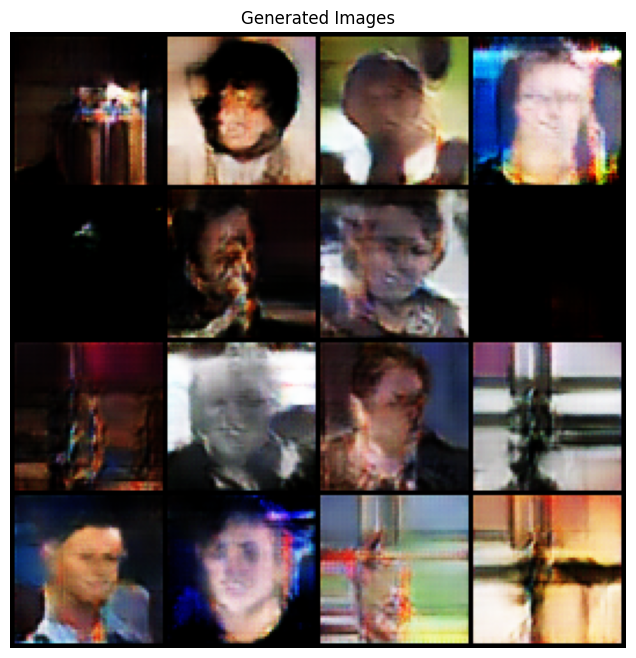

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Create a grid of images
grid = make_grid(fake_images, nrow=4, normalize=True, value_range=(-1, 1))

# Move the grid to the CPU and convert it to a NumPy array
grid_cpu = grid.permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC and move to CPU

# Plot the images using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(grid_cpu)
plt.axis('off')
plt.title("Generated Images")
plt.show()

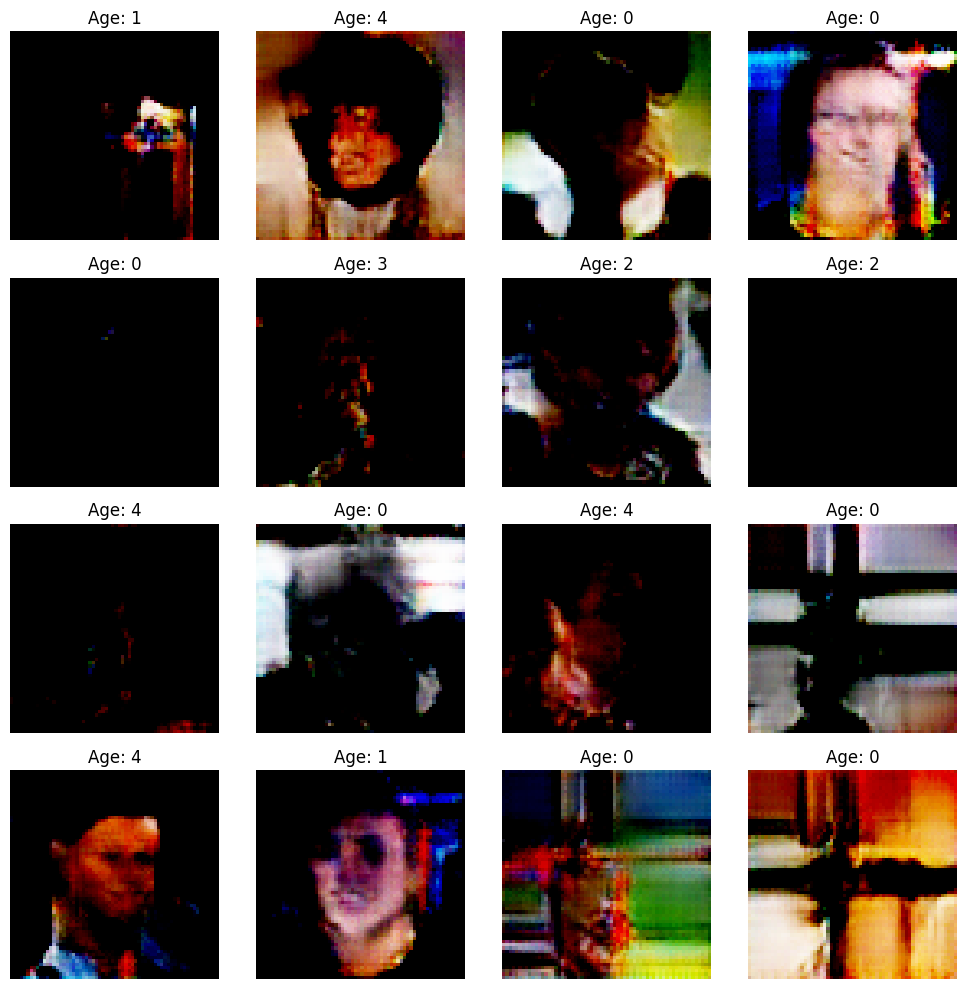

In [ ]:
import matplotlib.pyplot as plt

# Ensure `num_samples` does not exceed the size of `ages` or `fake_images`
num_samples = min(num_samples, len(ages), len(fake_images))

# Display generated images
plt.figure(figsize=(10, 10))  # Set the figure size

for i in range(num_samples):
    age_label = torch.argmax(ages[i]).item()  # Extract age label as an integer

    # Detach the image tensor, move to CPU, clamp to valid range, and convert to NumPy
    image = fake_images[i].detach().permute(1, 2, 0).clamp(0, 1).cpu().numpy()

    # Plot each image
    plt.subplot(4, 4, i + 1)  # Create a grid of 4x4 subplots
    plt.imshow(image)  # Display the image
    plt.title(f"Age: {age_label}")
    plt.axis('off')  # Remove axis for cleaner display

plt.tight_layout()
plt.show()